In [1]:
!pip install tensorflow keras

In [2]:
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
from tqdm.notebook import tqdm
from datetime import timedelta
import matplotlib.pyplot as plt
from IPython.display import Image
import plotly.graph_objects as go
from keras.utils import plot_model
from keras.models import Sequential
from IPython.display import Image, display
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from tensorflow.keras.layers import Embedding, SpatialDropout1D, Bidirectional, LSTM, Dense, Dropout

In [3]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/1VNIndex.xlsx' # Đường dẫn đã được cập nhật
df = pd.read_excel(file_path)

Mounted at /content/drive


In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [5]:
df.head()


,Price
Date,
2000-07-31,101.55
2000-08-02,103.38
2000-08-04,105.20
2000-08-07,106.92
2000-08-09,108.64


In [6]:
return_series=np.log(df['Price']/df['Price'].shift(1))

In [7]:
return_series = return_series.dropna()

In [8]:
return_series

,Price
Date,
2000-08-02,0.017860
2000-08-04,0.017452
2000-08-07,0.016218
2000-08-09,0.015959
2000-08-11,0.015708
...,...
2024-12-10,-0.001390
2024-12-11,-0.002527
2024-12-12,-0.001191


In [9]:
r_t=return_series.values.reshape(5931,1)

In [10]:
# prompt: đưa ra bảng mô tả thống kê, kurtosis, jacque cho r_t

import pandas as pd
import numpy as np

# Assuming 'return_series' and 'r_t' are defined as in the previous code
# ... (your existing code) ...

# Calculate descriptive statistics
r_t_series = pd.Series(r_t.flatten()) # Convert r_t to a pandas Series for easier calculations
description = r_t_series.describe()

# Calculate kurtosis and skewness (Fisher's definition)
kurtosis = r_t_series.kurtosis()
skewness = r_t_series.skew()


# Print the results
print("Descriptive Statistics:")
print(description)
print("\nKurtosis:", kurtosis)
print("\nSkewness (Fisher):", skewness)

# Create a summary table
summary_table = pd.DataFrame({
    'Statistic': ['Count', 'Mean', 'Standard Deviation', 'Min', '25%', '50%', '75%', 'Max', 'Kurtosis', 'Skewness'],
    'Value': [description['count'], description['mean'], description['std'], description['min'], description['25%'],
              description['50%'], description['75%'], description['max'], kurtosis, skewness]
})

print("\nSummary Table:")
summary_table

Descriptive Statistics:
count    5931.000000
mean        0.000425
std         0.014439
min        -0.076557
25%        -0.005534
50%         0.000607
75%         0.007378
max         0.066561
dtype: float64

Kurtosis: 3.4097427278606807

Skewness (Fisher): -0.3953987594767815

Summary Table:


,Statistic,Value
0,Count,5931.000000
1,Mean,0.000425
2,Standard Deviation,0.014439
3,Min,-0.076557
4,25%,-0.005534
5,50%,0.000607
6,75%,0.007378
7,Max,0.066561
8,Kurtosis,3.409743
9,Skewness,-0.395399


In [11]:
# prompt: đưa ra kết quả jacque bera test cho r_t

import numpy as np
import pandas as pd
from scipy.stats import jarque_bera

# Assuming 'r_t' is defined as in the previous code
# ... (your existing code) ...

# Perform Jarque-Bera test
jb_statistic, p_value = jarque_bera(r_t.flatten())

print("\nJarque-Bera Test:")
print("Statistic:", jb_statistic)
print("p-value:", p_value)

# Interpret the results
alpha = 0.05  # Significance level
if p_value < alpha:
    print("Reject the null hypothesis: The data does not follow a normal distribution.")
else:
    print("Fail to reject the null hypothesis: The data may follow a normal distribution.")


Jarque-Bera Test:
Statistic: 3021.0807048199413
p-value: 0.0
Reject the null hypothesis: The data does not follow a normal distribution.


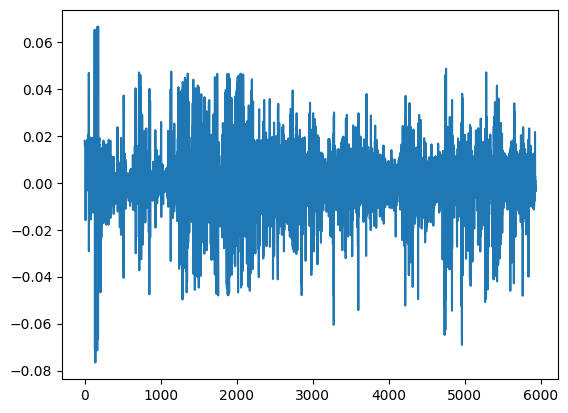

In [12]:
from matplotlib import pyplot as plt
plt.plot(r_t)
plt.show()

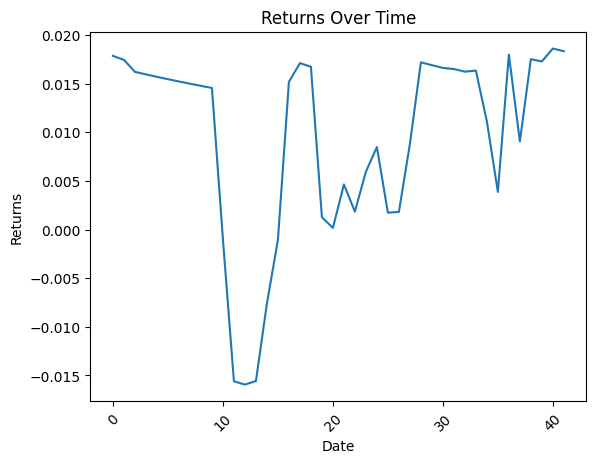

In [13]:
plt.plot(r_t[:42])
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Returns Over Time')
plt.show()

In [14]:
# prompt: Kiểm tra tính dừng r_t bằng các kiểm định như ADF test

!pip install statsmodels

from statsmodels.tsa.stattools import adfuller

# Assuming 'r_t' is defined as in the previous code
# ... (your existing code) ...

# Perform ADF test
result = adfuller(np.array(r_t).flatten())

print('\nAugmented Dickey-Fuller Test:')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# Interpret the results
if result[1] <= 0.05:
    print("Reject the null hypothesis: The time series is stationary.")
else:
    print("Fail to reject the null hypothesis: The time series is non-stationary.")


Augmented Dickey-Fuller Test:
ADF Statistic: -17.089139
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Reject the null hypothesis: The time series is stationary.


In [15]:
seq_len = 11
sequence = []
for index in range(len(r_t) - seq_len + 1):
    sequence.append(r_t[index: index + seq_len])
sequence = np.array(sequence)
print(sequence.shape)


(5921, 11, 1)


In [16]:
def split_data(sequence):
    train_data, test_data = train_test_split(sequence, test_size=0.4, shuffle=False,random_state=42)
    val_data, test_data = train_test_split(test_data, test_size=0.5, shuffle=False,random_state=42)
    return train_data, val_data, test_data

In [17]:

train_data, val_data, test_data = split_data(sequence)
print("Train:", train_data.shape, "Validation:", val_data.shape, "Test:", test_data.shape)

Train: (3552, 11, 1) Validation: (1184, 11, 1) Test: (1185, 11, 1)


In [18]:
# Concatenate train_data and val_data
combined_train_data = np.concatenate((train_data, val_data), axis=0)

print("Combined Train Data shape:", combined_train_data.shape)


Combined Train Data shape: (4736, 11, 1)


In [19]:

x_train = combined_train_data[:, :-1, :]
y_train = combined_train_data[:, -1, -1]
y_train2=y_train*100


x_test = test_data[:, :-1, :]
y_test = test_data[:, -1, -1]

# Kiểm tra kích thước của các tập dữ liệu
print(f"x_train shape: {x_train.shape}")  # (samples, timesteps * features)
print(f"y_train shape: {y_train.shape}")  # (samples,)
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (4736, 10, 1)
y_train shape: (4736,)
x_test shape: (1185, 10, 1)
y_test shape: (1185,)


In [20]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.1/985.1 kB 10.8 MB/s eta 0:00:00


In [21]:
import arch
import pandas as pd
import numpy as np

In [22]:
from arch import arch_model
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model

# Parameter ranges
m_values = range(1, 4)  # AR orders
n_values = range(1, 4)  # MA orders
p_values = range(1, 4)  # GARCH orders
q_values = range(1, 4)  # ARCH orders

best_model = None
best_bic = float('inf')

for m in m_values:
    for n in n_values:
        for p in p_values:
            for q in q_values:
                try:
                    # Fit ARMA model
                    arma_model = ARIMA(y_train2, order=(m, 0, n)).fit()

                    # Fit GARCH model to ARMA residuals
                    residuals = arma_model.resid
                    garch_model = arch_model(residuals, vol='Garch', p=p, q=q, dist='normal').fit(disp="off")

                    # Calculate BIC
                    bic = garch_model.bic
                    print(f"ARMA({m}, {n}) - GARCH({p}, {q}) | BIC: {bic}")

                    # Update best model if BIC is lower
                    if bic < best_bic:
                        best_bic = bic
                        best_model = (arma_model, garch_model)
                        best_params = (m, n, p, q)
                except Exception as e:
                    continue  # Skip invalid parameter combinations

# Output the best model and parameters
print(f"Best Parameters: ARMA({best_params[0]}, {best_params[1]}) - GARCH({best_params[2]}, {best_params[3]})")
print(f"Minimum BIC: {best_bic}")




ARMA(1, 1) - GARCH(1, 1) | BIC: 14563.323202575059
ARMA(1, 1) - GARCH(1, 2) | BIC: 14566.054291961951
ARMA(1, 1) - GARCH(1, 3) | BIC: 14564.69350957808
ARMA(1, 1) - GARCH(2, 1) | BIC: 14571.786150463213
ARMA(1, 1) - GARCH(2, 2) | BIC: 14574.517239584184
ARMA(1, 1) - GARCH(2, 3) | BIC: 14573.016318260605
ARMA(1, 1) - GARCH(3, 1) | BIC: 14580.249095620014
ARMA(1, 1) - GARCH(3, 2) | BIC: 14582.98018702789
ARMA(1, 1) - GARCH(3, 3) | BIC: 14581.479262424014
ARMA(1, 2) - GARCH(1, 1) | BIC: 14548.981123924204
ARMA(1, 2) - GARCH(1, 2) | BIC: 14551.756551366787
ARMA(1, 2) - GARCH(1, 3) | BIC: 14550.3451524797
ARMA(1, 2) - GARCH(2, 1) | BIC: 14557.444071830874
ARMA(1, 2) - GARCH(2, 2) | BIC: 14560.219499266661
ARMA(1, 2) - GARCH(2, 3) | BIC: 14558.634573999985
ARMA(1, 2) - GARCH(3, 1) | BIC: 14565.907020656312
ARMA(1, 2) - GARCH(3, 2) | BIC: 14568.682447267138
ARMA(1, 2) - GARCH(3, 3) | BIC: 14567.09752218
ARMA(1, 3) - GARCH(1, 1) | BIC: 14549.976167670426
ARMA(1, 3) - GARCH(1, 2) | BIC: 14552.8

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARMA(3, 2) - GARCH(1, 1) | BIC: 14552.750804706147


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARMA(3, 2) - GARCH(1, 2) | BIC: 14555.308708218383


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARMA(3, 2) - GARCH(1, 3) | BIC: 14553.89529771426


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARMA(3, 2) - GARCH(2, 1) | BIC: 14561.213767747216


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARMA(3, 2) - GARCH(2, 2) | BIC: 14563.771656395498


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARMA(3, 2) - GARCH(2, 3) | BIC: 14562.257338722786


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARMA(3, 2) - GARCH(3, 1) | BIC: 14569.676717549302


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARMA(3, 2) - GARCH(3, 2) | BIC: 14572.234604144287


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARMA(3, 2) - GARCH(3, 3) | BIC: 14570.720285962112
ARMA(3, 3) - GARCH(1, 1) | BIC: 14562.107810125486
ARMA(3, 3) - GARCH(1, 2) | BIC: 14564.932200628169
ARMA(3, 3) - GARCH(1, 3) | BIC: 14563.558781689064
ARMA(3, 3) - GARCH(2, 1) | BIC: 14570.570758301455
ARMA(3, 3) - GARCH(2, 2) | BIC: 14573.395148699781
ARMA(3, 3) - GARCH(2, 3) | BIC: 14571.869683012035
ARMA(3, 3) - GARCH(3, 1) | BIC: 14579.033706481283
ARMA(3, 3) - GARCH(3, 2) | BIC: 14581.858097297414
ARMA(3, 3) - GARCH(3, 3) | BIC: 14580.33262546594
Best Parameters: ARMA(1, 2) - GARCH(1, 1)
Minimum BIC: 14548.981123924204


In [23]:
# Output the best model summary
arma_model, garch_model = best_model
print(arma_model.summary())
print("\nGARCH Model Summary:")

print(garch_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4736
Model:                 ARIMA(1, 0, 2)   Log Likelihood               -8389.500
Date:                Wed, 01 Jan 2025   AIC                          16789.001
Time:                        05:53:30   BIC                          16821.315
Sample:                             0   HQIC                         16800.358
                               - 4736                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0334      0.047      0.713      0.476      -0.058       0.125
ar.L1          0.9478      0.011     87.690      0.000       0.927       0.969
ma.L1         -0.6821      0.014    -50.296      0.0

In [24]:
arma_pred = arma_model.predict(start=len(y_train2), end=len(y_train2) + len(y_test) - 1)

# Dự đoán sự biến động từ GARCH (conditional volatility)
garch_volatility = garch_model.conditional_volatility

# Kết hợp dự đoán ARMA và GARCH để có dự đoán cuối cùng
# Dự đoán cuối cùng sẽ là giá trị ARMA cộng với sự biến động từ GARCH
final_pred = arma_pred + garch_volatility[:len(arma_pred)]

predictions=final_pred/100
predictions

array([0.0051681 , 0.00275493, 0.00463969, ..., 0.00711608, 0.00719689,
       0.00678981])

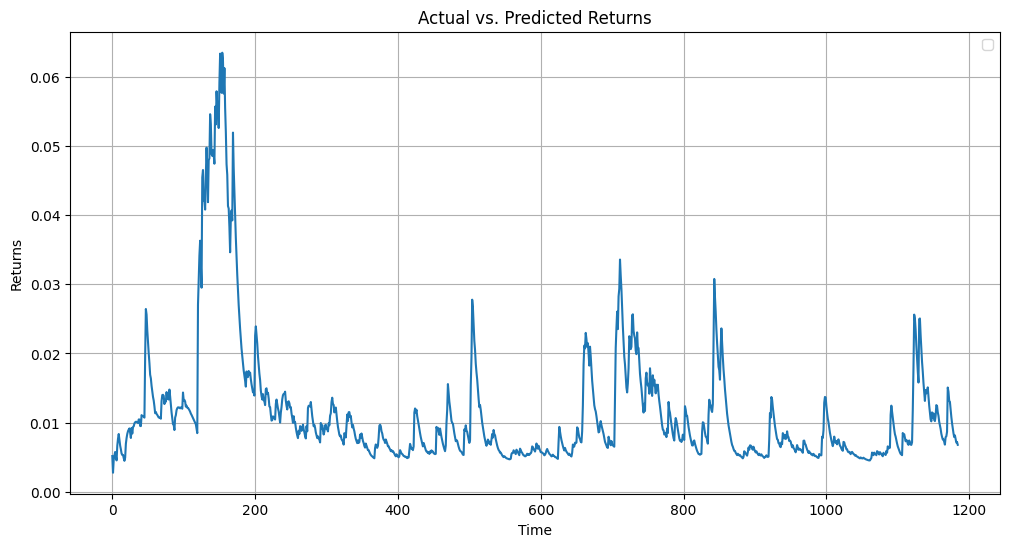

In [25]:
# prompt: vẽ biểu đồ predictions

import matplotlib.pyplot as plt

# Assuming 'predictions' and 'y_test' are defined as in the previous code
# ... (your existing code) ...

# Create the plot
plt.figure(figsize=(12, 6))

plt.plot(predictions)
# Add labels and title
plt.xlabel('Time')
plt.ylabel('Returns')
plt.title('Actual vs. Predicted Returns')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
import tensorflow as tf
r_t_test = tf.cast(y_test, dtype=tf.float32)  # Ép kiểu y_true về tf.float32
sigma_t = tf.cast(predictions, dtype=tf.float32) # Cast y_pred to tf.float32 as well
# Constants
import math
pi=math.pi

log_L = np.sum(-0.5 * np.log(2 *pi) - np.log(sigma_t) - (r_t_test**2) / (2 * sigma_t**2))
log_L

2844.755

In [27]:
# prompt: xuất giá trị predictions ra excel và lưu vào drive

import pandas as pd
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Assuming 'predictions' is a NumPy array containing your model's predictions
# Create a Pandas DataFrame from the predictions
predictions_df = pd.DataFrame(predictions, columns=['Predicted Volatility'])

# Specify the output file path in your Google Drive
output_file_path = '/content/drive/MyDrive/predictionsarmagarch.xlsx'

# Export the DataFrame to an Excel file
predictions_df.to_excel(output_file_path, index=False)

print(f"Predictions exported to: {output_file_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Predictions exported to: /content/drive/MyDrive/predictionsarmagarch.xlsx
